This is my brief but also took way too long EDA for the COMPAS data

Here I'm just filtering out the information I didn't think was too relevant

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
y= pd.read_csv("compas-scores.csv")

colremove = ['c_jail_in', 'c_jail_out','r_jail_in', "r_case_number", "v_type_of_assessment", "type_of_assessment", "compas_screening_date", "v_screening_date", "dob", "name", "num_r_cases", "c_case_number", "c_days_from_compas", "c_charge_degree", "c_charge_desc", "r_charge_desc", 'r_jail_out', "vr_charge_degree",	"num_vr_cases", "vr_case_number", "vr_offense_date", "vr_charge_desc", 'days_b_screening_arrest',  'c_offense_date', 'c_arrest_date', 'screening_date', 'r_offense_date', 'r_charge_degree', 'r_days_from_arrest']

Compas = y.drop(colremove, axis =1)

Compas.head()

,id,first,last,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,v_score_text,decile_score.1,score_text
0,1,miguel,hernandez,Male,69,Greater than 45,Other,0,1,0,0,0,0,0,1,Low,1,Low
1,2,michael,ryan,Male,31,25 - 45,Caucasian,0,5,0,0,0,-1,0,2,Low,5,Medium
2,3,kevon,dixon,Male,34,25 - 45,African-American,0,3,0,0,0,1,1,1,Low,3,Low
3,4,ed,philo,Male,24,Less than 25,African-American,0,4,0,1,4,1,0,3,Low,4,Low
4,5,marcu,brown,Male,23,Less than 25,African-American,0,8,1,0,1,0,0,6,Medium,8,High


Now I'm going about making a data set that filters by race, sex, and the measured risk of recidivism (score_text)

In [206]:
yn = Compas.groupby(["race", "sex", "score_text"])
y4 = yn[["id"]].count()
y4.head(10)

id
race             sex    score_text      
African-American Female High         209
                        Low          567
                        Medium       340
                 Male   High        1414
                        Low         1912
                        Medium      1365
Asian            Female Low            6
                        Medium         1
                 Male   High           4
                        Low           38

I'm now adding in a way to determine the % of each of gender/race category that is in high, medium and low risk. First I'm creating an array that sums the total number of African American Women, African American Men, Asian women, etc.

In [197]:

Compas2 = [y4.loc["African-American", "id"].loc["Female"].sum(),
      y4.loc["African-American", "id"].loc["Male"].sum(),
      y4.loc["Asian", "id"].loc["Female"].sum(),
      y4.loc["Asian", "id"].loc["Male"].sum(),
      y4.loc["Caucasian", "id"].loc["Female"].sum(),
      y4.loc["Caucasian", "id"].loc["Male"].sum(),
      y4.loc["Hispanic", "id"].loc["Female"].sum(),
      y4.loc["Hispanic", "id"].loc["Male"].sum(),
      y4.loc["Native American", "id"].loc["Female"].sum(),
      y4.loc["Native American", "id"].loc["Male"].sum(),
      y4.loc["Other", "id"].loc["Female"].sum(),
      y4.loc["Other", "id"].loc["Male"].sum(),
     ]
Compas2

[1116, 4691, 7, 51, 965, 3112, 189, 911, 10, 30, 130, 530]

This is just me fixing the array I made before I add it a a column because one of the rows didn't have any data and the columns weren't the same length.

In [211]:
Compas3 = np.repeat(Compas2, 3)

rt = list(Compas3)

rt.pop(6)

7

Now I'm finally making the new column

In [212]:
y4['totals'] = rt

y4["% of gender/race category"] = round(y4["id"]/y4["totals"]*100, 1)
COMPAS2 = y4.drop("totals", axis =1)

COMPAS2.head(10)

id  % of gender/race category
race             sex    score_text                                 
African-American Female High         209                       18.7
                        Low          567                       50.8
                        Medium       340                       30.5
                 Male   High        1414                       30.1
                        Low         1912                       40.8
                        Medium      1365                       29.1
Asian            Female Low            6                       85.7
                        Medium         1                       14.3
                 Male   High           4                        7.8
                        Low           38                       74.5

Now I'm making a pivot table with the data, showing how overall African Americans are overrepresented in the High and Medium risk percentages.

In [213]:
COMPAS3 =COMPAS2.reset_index() 

COMPASPIVOT = COMPAS3.pivot_table(
    values = "% of gender/race category",
    index = 'race', 
    columns = 'score_text'
)

COMPASPIVOT

score_text,High,Low,Medium
race,,,
African-American,24.40,45.80,29.80
Asian,7.80,80.10,15.95
Caucasian,10.95,65.65,23.40
Hispanic,6.90,76.30,16.80
Native American,18.35,55.00,26.65
Other,3.85,80.85,15.25


Finally, I'm plotting this data in bar graphs split up by both race, and gender

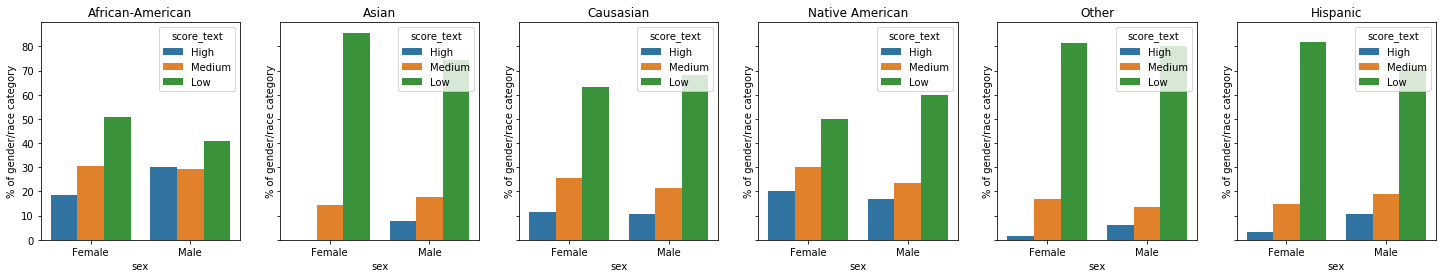

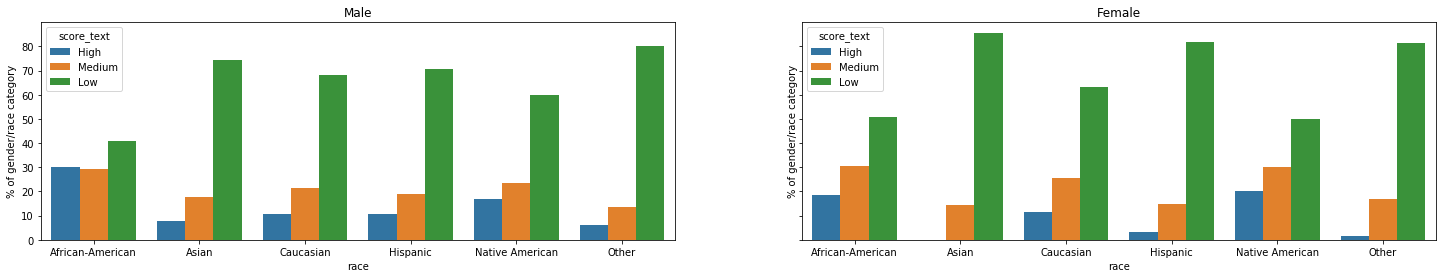

In [214]:
r1 = COMPAS3[(COMPAS3.race == "African-American")]
r2 = COMPAS3[(COMPAS3.race == "Asian")]
r3 = COMPAS3[(COMPAS3.race == "Caucasian")]
r4 = COMPAS3[(COMPAS3.race == "Native American")]
r5 = COMPAS3[(COMPAS3.race == "Other")]
r6 = COMPAS3[(COMPAS3.race == "Hispanic")]
r7 = COMPAS3[(COMPAS3.race == "Oriental")]
r8 = COMPAS3[(COMPAS3.race == "Arabic")]

m1 = COMPAS3[(COMPAS3.sex == "Male")]
m2 = COMPAS3[(COMPAS3.sex == "Female")]

import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 6, sharey=True, figsize=(25, 4))
rac1 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("African-American")
rac2 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Asian")
rac3 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r3, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[2])).set_title("Causasian")
rac4 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r4, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[3])).set_title("Native American")
rac5 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r5, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[4])).set_title("Other")
rac6 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r6, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[5])).set_title("Hispanic")

f, axes = plt.subplots(1, 2, sharey=True, figsize=(25, 4))
sex1 = (sns.barplot(x= "race" , y="% of gender/race category", data=m1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("Male")
sex2 = (sns.barplot(x= "race" , y="% of gender/race category", data=m2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Female")



^Note how african american men are disproportionately identified as high risk for recidivism

Now I'm creating a heatmap of recidivism likelihood scores based upon the score given to men and women and age-range 

In [215]:
 yy = y.pivot_table(
    values = 'decile_score.1', 
    index = 'sex', 
    columns = 'age'
)
yy=yy.fillna(0)

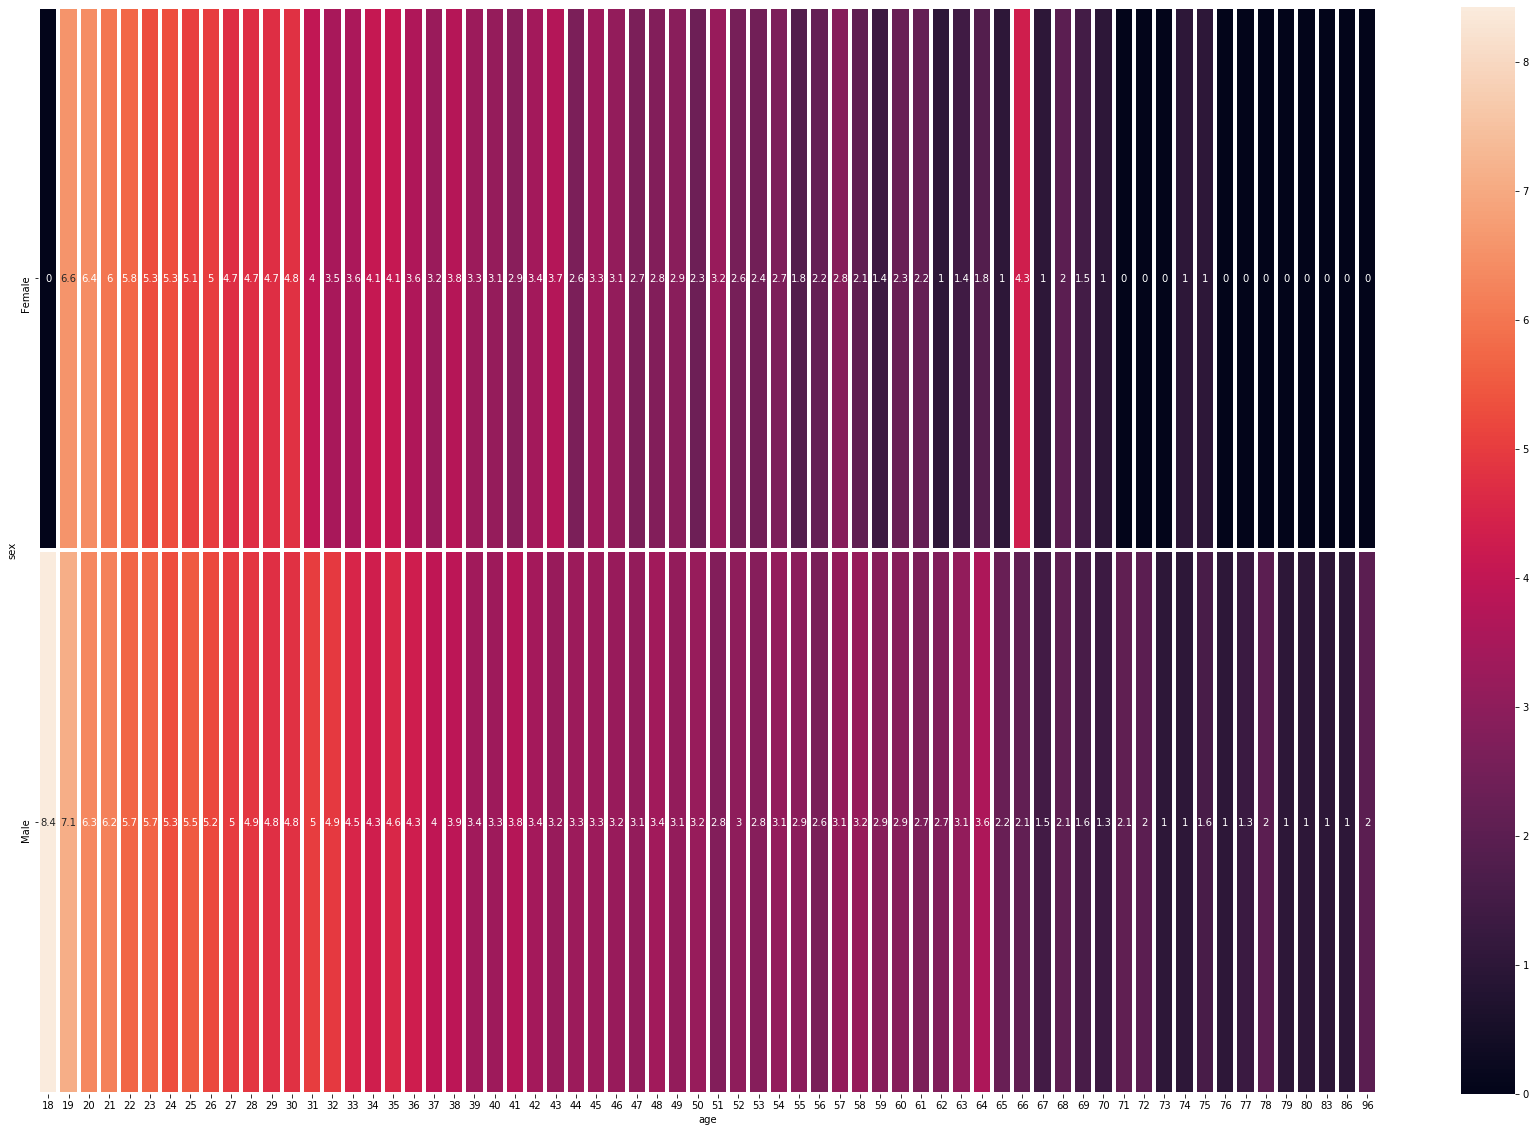

In [216]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(yy, annot=True, linewidths=3, ax=ax)

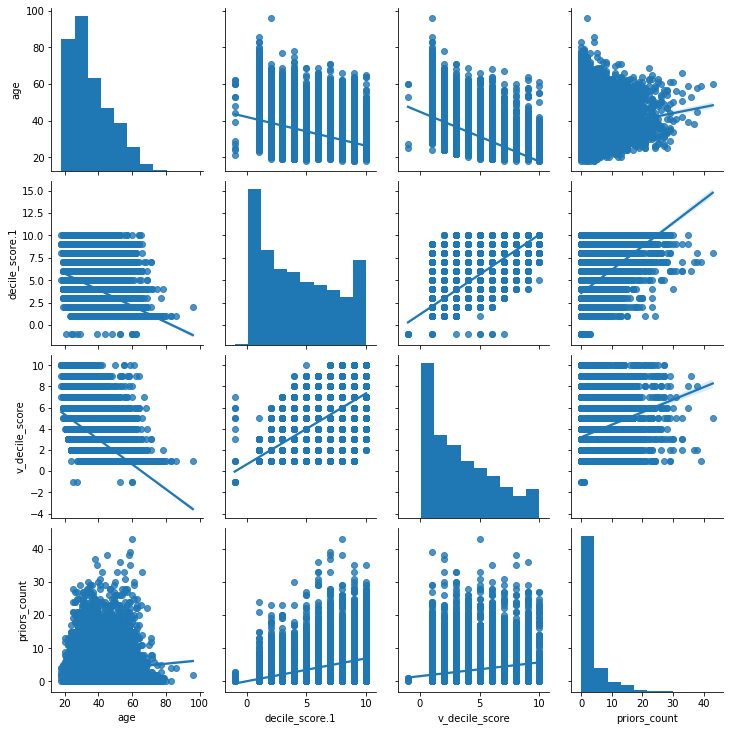

In [185]:
COMPAS1 = y[['age','decile_score.1', 'v_decile_score','priors_count']]
sns.pairplot(COMPAS1, kind='reg')